<a href="https://colab.research.google.com/github/RaminSoleimani/DP_FeD_Household_Energy/blob/main/multi_federation_DP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install tensorflow-federated

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.6/70.6 MB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.8/104.8 kB 14.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 kB 16.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 721.6/721.6 kB 62.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.7/73.7 MB 24.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 77.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 90.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.7/33.7 MB 55.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 257.7/257.7 kB 33.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 241.2/241.2 kB 31.8 MB/s eta 0:00:00
     ━━━━

In [ ]:
import collections
import numpy as np
import tensorflow as tf
import tensorflow_federated as tff
import pandas as pd
import pickle
import os

In [ ]:
@tff.federated_computation
def hello_world():
  return 'Hello, World!'

hello_world()

b'Hello, World!'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
file_path = '/content/drive/MyDrive/Multi_tier_Fed_STLF_lists/list_of_18_clusters_1800'
with open(file_path, 'rb') as file:
    Mul_tie_fed_data_list = pickle.load(file)
print(len(Mul_tie_fed_data_list))

18


In [ ]:
print(len(Mul_tie_fed_data_list[17][0]))

32179


In [ ]:
#create a list to contain all users of one group(federation) in a single list for normalizing purpose
entire_data_across_users=[]
count=0
for lis in Mul_tie_fed_data_list:
  for item in lis:
    entire_data_across_users.extend(item.values.reshape(-1,1))
    count=count+len(item)
print(count)

55416075


In [ ]:
print(len(entire_data_across_users))

55416075


In [ ]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
scaler_std = StandardScaler()
scaler_std.fit(entire_data_across_users)

StandardScaler()

In [ ]:
#golbal variable
class G:
    SPLIT_TIME = 0.9  #25600
    WINDOW_SIZE = 8
    BATCH_SIZE = 32
    SHUFFLE_BUFFER_SIZE = 1000

#Creat dataset for a single user
def create_dataset(series, window_size):
    X = []
    y = []
    for i in range(len(series) - window_size):
        X.append(series[i : i + window_size])
        y.append(series[i + window_size])
    X=np.array(X)
    y=np.array(y)


    split_index = int(len(X) * G.SPLIT_TIME)

    X_train, X_test = X[:split_index], X[split_index:]
    y_train, y_test = y[:split_index], y[split_index:]
    # Convert the data into TensorFlow Datasets
    train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
    test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))

    # Shuffle and batch the datasets
    batch_size = G.BATCH_SIZE
    train_dataset = train_dataset.shuffle(len(X_train)).batch(batch_size)
    test_dataset = test_dataset.batch(batch_size)

    return train_dataset, test_dataset

def train_test_multi_fed_data(clustered_multi_federated_data,scaler):
    window_size=G.WINDOW_SIZE
    multi_tier_fed_train_data=[]
    multi_tier_fed_test_data=[]
    for item in clustered_multi_federated_data:
        train_data_lis=[]
        test_data_lis=[]
        for series in item:
            series=series.values.reshape(-1,1)
            #norm_series=scaler.fit_transform(series)
            norm_series=scaler.transform(series) # scaler is already fit with the entire data
            train_dataset,test_dataset=create_dataset(norm_series,window_size)
            train_data_lis.append(train_dataset)
            test_data_lis.append(test_dataset)

        multi_tier_fed_train_data.append(train_data_lis)
        multi_tier_fed_test_data.append(test_data_lis)
    return multi_tier_fed_train_data, multi_tier_fed_test_data
multi_tier_fed_train_dataset, multi_tier_fed_test_dataset=train_test_multi_fed_data(Mul_tie_fed_data_list,scaler_std)

In [ ]:
print(len(multi_tier_fed_test_dataset[0]))

100


In [ ]:
def create_uncompiled_model_CONVLSTM(window_size):
    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv1D(filters=64, kernel_size=3,
                               strides=1,
                               activation="relu",
                               padding='causal',
                               input_shape=[window_size, 1]),
        tf.keras.layers.LSTM(128, return_sequences=True),
        tf.keras.layers.LSTM(128),
        tf.keras.layers.Dense(30, activation="relu"),
        tf.keras.layers.Dense(10, activation="relu"),
        tf.keras.layers.Dense(1)
    ])
    return model

def model_fn():
  # We _must_ create a new model here, and _not_ capture it from an external
  keras_model = create_uncompiled_model_CONVLSTM(G.WINDOW_SIZE)
  return tff.learning.models.from_keras_model(
      keras_model,
      input_spec=multi_tier_fed_train_dataset[0][0].element_spec,
      loss=tf.keras.losses.MeanSquaredError(),
      metrics=[tf.keras.metrics.MeanSquaredError(),tf.keras.metrics.MeanAbsoluteError()])

In [ ]:
num_federations=len(multi_tier_fed_train_dataset)
print(num_federations)

18


In [ ]:
def create_DP_learning_processes(num_federations, noise_multiplier,  clients_per_round, learning_rate ):

  #list to cotain tff learning process for all federations
  list_of_learning_processes=[]

  #list to contain the states for all federations
  list_of_states=[]

  for i in range(num_federations):
    # Using the `dp_aggregator` here turns on differential privacy with adaptive
    # clipping.
    aggregation_factory = tff.learning.model_update_aggregator.dp_aggregator(
      noise_multiplier, clients_per_round)

    learning_process = tff.learning.algorithms.build_unweighted_fed_avg(
        model_fn,
        client_optimizer_fn=lambda: tf.keras.optimizers.SGD(learning_rate),
        server_optimizer_fn=lambda: tf.keras.optimizers.SGD(1.0, momentum=0.9),
        model_aggregator=aggregation_factory)

    list_of_learning_processes.append(learning_process)

  for learn_proc in list_of_learning_processes:
     # Training loop.
     list_of_states.append(learn_proc.initialize())

  return list_of_learning_processes, list_of_states

In [ ]:
def train(rounds, noise_multiplier, clients_per_round, data_frame,learning_rate,total_clients,train_data,test_data):


  # clients per round is stochastic with mean clients_per_round.
  sampling_prob = clients_per_round / total_clients



  for round in range(rounds):
    if round % 5 == 0:
      model_weights = learning_process.get_model_weights(state)
      metrics = eval_process(model_weights, [test_data])['eval']
      if round < 25 or round % 25 == 0:
        print(f'Round {round:3d}: {metrics}')
      data_frame = data_frame.append({'Round': round,
                                      'NoiseMultiplier': noise_multiplier,
                                      **metrics}, ignore_index=True)

    # Sample clients for a round. Note that if your dataset is large and
    # sampling_prob is small, it would be faster to use gap sampling.
    x = np.random.uniform(size=total_clients)
    sampled_train_data = [
        train_data[i] for i in range(total_clients)
        if x[i] < sampling_prob]


    # Use selected clients for update.
  result = learning_process.next(state, sampled_train_data)
  state = result.state


  model_weights = learning_process.get_model_weights(state)
  metrics = eval_process(model_weights, [test_data])['eval']
  print(f'Round {rounds:3d}: {metrics}')
  data_frame = data_frame.append({'Round': rounds,
                                  'NoiseMultiplier': noise_multiplier,
                                  **metrics}, ignore_index=True)

  return  model_weights

In [ ]:
noise_multiplier=0.1167
clients_per_round=10
learning_rate=9e-5
num_federations=len(multi_tier_fed_train_dataset)
list_of_learning_processes, list_of_states=create_DP_learning_processes(num_federations, noise_multiplier,  clients_per_round, learning_rate )

In [ ]:
# Create a list of weights of all the local servers
fed_server_wieght_lis = [x.get_model_weights(y).trainable for x, y in zip(list_of_learning_processes, list_of_states)]

#create aggregation process for global model update

In [ ]:
@tff.tf_computation
def server_init():
  model = model_fn()
  return model.trainable_variables
model_weights_type = server_init.type_signature.result

aggregationfacotry=tff.aggregators.UnweightedMeanFactory()

global_aggregation_process=aggregationfacotry.create(model_weights_type)

global_state=global_aggregation_process.initialize()

In [ ]:
global_output=global_aggregation_process.next(global_state,fed_server_wieght_lis)
global_state=global_output.state
global_weights=global_output.result
print(global_weights[0])

In [ ]:
#create tff modelweights object from result of global federation, requiered type for set_model_weights of tff learning process
glob_fed_weights=tff.learning.models.ModelWeights(global_weights, [])

In [ ]:
# set the local server weights with the global weights
for i in range(0,len(list_of_learning_processes)):
  list_of_states[i]=list_of_learning_processes[i].set_model_weights(list_of_states[i],glob_fed_weights)

In [ ]:
def sample_users_local(single_fed_data,total_clients,sampling_prob):
    x = np.random.uniform(size=total_clients)
    sampled_user = [
        single_fed_data[i] for i in range(total_clients)
        if x[i] < sampling_prob]
    return sampled_user

def local_fed_iteration():
  return

In [ ]:
# craete a model from weights
model_evaluation=create_uncompiled_model_CONVLSTM(G.WINDOW_SIZE)

#Create IID test dataset for evaluating the final server update against IID data across all the users in the federation

In [ ]:
print(type(multi_tier_fed_test_dataset[0]))
from functools import reduce
dataset_list=[]

i=0
j=0
for fed  in multi_tier_fed_test_dataset:
  i=i+1
  for fed_dataset_tst in fed:
    j=j+1
    dataset_list.append(fed_dataset_tst)


print(len(multi_tier_fed_test_dataset))
print(i)
print(j)
print(len(dataset_list))
# Use functools.reduce to concatenate the datasets in the list
cross_combined_dataset = reduce(tf.data.Dataset.concatenate, dataset_list)

print(type(cross_combined_dataset))
print(len(cross_combined_dataset))
# print(len(dataset_list))
test_set_size = int(len(cross_combined_dataset)/1800)
print(test_set_size)

# # Shuffle the combined dataset
shuffled_dataset = cross_combined_dataset.shuffle(buffer_size=len(cross_combined_dataset)*32)

print('suffle',len(shuffled_dataset))

# # take a portion of the shuffled dataset as your test set
IID_test_dataset = shuffled_dataset.take(test_set_size*2)
None_IID_test_dateset=multi_tier_fed_test_dataset[0][0]

print(len(IID_test_dataset))
print(len(None_IID_test_dateset))

<class 'list'>
18
18
1800
1800
<class 'tensorflow.python.data.ops.concatenate_op._ConcatenateDataset'>
174004
96
suffle 174004
192
76


#Extract the datapoits and labels from IID test dataset created in the previous sections

In [ ]:
def unbatch_spr_dtpnt_lbl(IID_tst_dataset):
  # Unbatch the dataset
  IID_test_dataset_unbatch = IID_tst_dataset.unbatch()

  IID_test_dataset_datapoints=[]
  IID_test_dataset_labels=[]

  for data_point, label in IID_test_dataset_unbatch:
    # 'data_point' and 'label' are individual data points and their labels
    #print("Data Point:", data_point.numpy())
    IID_test_dataset_datapoints.append(data_point.numpy())
    #print("Label:", label.numpy())
    IID_test_dataset_labels.append(label.numpy())
  IID_test_dataset_datapoints=np.array(IID_test_dataset_datapoints)
  IID_test_dataset_labels=np.array(IID_test_dataset_labels)

  return IID_test_dataset_datapoints,IID_test_dataset_labels


# print(IID_test_dataset_datapoints.shape)
# print(IID_test_dataset_labels.shape)
# # Unbatch the dataset
# IID_test_dataset_unbatch = IID_test_dataset.unbatch()

# IID_test_dataset_datapoints=[]
# IID_test_dataset_labels=[]

# for data_point, label in IID_test_dataset_unbatch:
#     # 'data_point' and 'label' are individual data points and their labels
#     print("Data Point:", data_point.numpy())
#     IID_test_dataset_datapoints.append(data_point.numpy())
#     print("Label:", label.numpy())
#     IID_test_dataset_labels.append(label.numpy())
# IID_test_dataset_datapoints=np.array(IID_test_dataset_datapoints)
# IID_test_dataset_labels=np.array(IID_test_dataset_labels)

#helper function to compute metrcis for the model performance on on the testset

In [ ]:
def compute_metrics(true_series, forecast):

    ''' first section  the errors based on absolute error'''


    mae=np.mean(np.abs(true_series-forecast))

    #Compute Relative Absolute Error(RAE), can only range from zero to one
    # true_mean=np.mean(true_series)
    # abs_error_sum=np.sum(np.abs(true_series-forecast))
    # true_deviation_sum=np.sum(np.abs(true_series-true_mean))
    # rae=abs_error_sum/true_deviation_sum
    numerator = np.sum(np.abs(forecast - true_series))

    denominator = np.sum(np.abs(np.mean(true_series) - true_series))
    rae=numerator / denominator

    #compute Mean Absolute Percetage Error(MAPE)
    # abs_error=(np.abs(true_series-forecast))/true_series
    # mape=np.mean(abs_error)*100

    #mape = np.mean(np.abs(np.divide((true_series - forecast), true_series, out=np.zeros_like(true_series), where=true_series != 0))) * 100

    mape=np.mean(np.abs((true_series - forecast) / (true_series))) * 100

    ''' second section the errors based on squered errors '''
    #Compute Mean Squared Error
    # mse = tf.keras.losses.MeanSquaredError()
    # mse=mse(true_series, forecast).numpy()
    mse=np.mean(np.square(true_series-forecast))
    #Compute  Root Mean Squared Error (RMSE)
    #rmse=math.sqrt(mse)
    rmse=np.sqrt(np.mean(np.square(true_series-forecast)))
    #Compute Relative  Squared Error,The output value of RSE is expressed in terms of ratio. It can range from zero to one.
    true_mean=np.mean(true_series)
    squared_error_sum=np.sum(np.square(true_series-forecast))
    squared_true_dev_sum=np.sum(np.square(true_series-true_mean))
    rse=squared_error_sum/squared_true_dev_sum

    #Compute
    ''' Third section MBE'''
    #Compute mean bias error,This evaluation metric quantifies the overall bias and captures the average bias in the prediction.
    mbe=np.mean(true_series-forecast)

    return mae,rae,mape,mse,rse,mbe,rmse

#evalution functions

In [ ]:
def evaluation_model(model,dataset,sclr_std):
  IID_tst_dtset_dtpoints,IID_tst_dtset_lbls=unbatch_spr_dtpnt_lbl(dataset)

  #make predictions
  forcast_IDD_tstset=model_evaluation.predict(IID_tst_dtset_dtpoints)

  # Find indices where the array has zero values
  zero_indices = np.where(IID_tst_dtset_lbls == 0)[0]
  # Print the indices
  print("Indices of zero values:", zero_indices)

  # Remove elements at the zero indices
  forcast_IDD_tstset = np.delete(forcast_IDD_tstset, zero_indices)
  IID_tst_dtset_lbls = np.delete(IID_tst_dtset_lbls, zero_indices)

  #inverse scale to produce the real scale data using the fitted scaler on the entire data across all users
  predictions_scaled = sclr_std.inverse_transform(forcast_IDD_tstset.reshape(1, -1)).squeeze()
  IID_tst_dtset_lbls_scaled=scaler_std.inverse_transform(IID_tst_dtset_lbls.reshape(1, -1)).squeeze()

  mae,rae,mape,mse,rse,mbe,rmse=compute_metrics( IID_tst_dtset_lbls_scaled,predictions_scaled)

  return {'mae':mae,'rae':rae,'mape':mape,'mse':mse,'rse':rse,'rmse':rmse,'mbe':mbe}

In [ ]:
from functools import reduce
import datetime
global_rounds=100
local_rounds=4
total_local_clients=len(multi_tier_fed_train_dataset[0])
data_frame_mtr=pd.DataFrame()
# We use Poisson subsampling which gives slightly tighter privacy guarantees
# compared to having a fixed number of clients per round. The actual number of
# clients per round is stochastic with mean clients_per_round.
sampling_prob = clients_per_round / total_local_clients
print(sampling_prob)
for glob_round in range(0,global_rounds):

  for round in range(0,local_rounds):

    #result_lis,list_of_states=local_fed(multi_tier_fed_train_dataset,total_local_clients,sampling_prob,list_of_learning_processes,list_of_states)

    #create a list of sampled clients of each federation
    sampled_clients_lis=[]
    sampled_size=[]
    for single_fed_data in multi_tier_fed_train_dataset:
      # performe sampling for each federation dataset and put them in the sampled_clients_lis list
      sampled_clients=sample_users_local(single_fed_data,total_local_clients,sampling_prob)
      sampled_clients_lis.append(sampled_clients)
      sampled_size.append(len(sampled_clients))
    sum_sample=reduce(lambda x, y: x + y, sampled_size)
    print('sampling is done and the sizes of the samples are {} the total size is {} '.format(sampled_size, sum_sample) )

    #performe a round of learning for each federation using sampled users
    result_lis = [x.next(y,z) for x, y, z in zip(list_of_learning_processes, list_of_states, sampled_clients_lis)]

    #update the list of local servers
    list_of_states =[x.state for x in result_lis]

  ''' update the global serever  using the local server weights'''
  # extraxt the weights of the local servers and create a list out put of them
  local_server_wieghts=[ x.get_model_weights(y).trainable for x, y in zip(list_of_learning_processes,list_of_states)]

  #update the global server
  global_output=global_aggregation_process.next(global_state,local_server_wieghts)

  global_state=global_output.state
  global_server_weights=global_output.result

  ''' updatae the local servers using the global weights'''

  #create tff modelweights object from result of global federation, requiered type for set_model_weights of tff learning process
  glob_fed_weights=tff.learning.models.ModelWeights(global_server_weights, [])

  print(" global server update is done")

  #update the local federation server  with global weights and update the state list according to new updates
  list_of_states=[x.set_model_weights(y,glob_fed_weights) for x ,y in zip(list_of_learning_processes, list_of_states)]
  #list_of_states[i]=list_of_learning_processes[i].set_model_weights(list_of_states[i],glob_fed_weights)

  print("local server updates are done")

  ''' computing the accuracy metrics of the global model on the IID test dataset'''
  #set the model weights wiht global server weights
  model_evaluation.set_weights(global_server_weights)
  metrics_dic=evaluation_model(model_evaluation,IID_test_dataset,scaler_std)

  #save the metrics per round in a dataframe
  print(f'Round {glob_round:3d}: {metrics_dic}')
  data_frame_mtr = data_frame_mtr.append({'Round': glob_round,'learning_rate':learning_rate,
                                  'NoiseMultiplier': noise_multiplier,
                                  **metrics_dic}, ignore_index=True)




  # Use selected clients for update.
  #result_lis = [x.next(y,z) for x, y, z in zip(list_of_learning_processes, list_of_states, sampled_clients_lis)]
  #list_of_states =[x.state for x in result_lis]
  print('iteration number is {},global round is {} ,'.format(glob_round*(local_rounds)+round+1,glob_round+1))
# Generate a unique identifier using the current date and time
timestamp = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
fed_train_dataframe = r'/content/drive/MyDrive/DP_FED_LSTM_RESULTS/mult_fed_dp/data_frame_{}_{}_{}_{}_{}_{}.pkl'.format(timestamp,global_rounds,total_local_clients,clients_per_round,noise_multiplier,learning_rate)
server_weights_file = r'/content/drive/MyDrive/DP_FED_LSTM_RESULTS/mult_fed_dp/weights_{}_{}_{}_{}_{}_{}.pkl'.format(timestamp,global_rounds,total_local_clients,clients_per_round,noise_multiplier,learning_rate)

with open(fed_train_dataframe,'wb') as file:
  pickle.dump(data_frame_mtr, file)
with open(server_weights_file,'wb') as file:
  pickle.dump(global_server_weights, file)

NameError: ignored

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

def make_plot(data_frame):
  plt.figure(figsize=(15, 5))

  dff = data_frame.rename(
      columns={'mae': 'mae', 'mse': 'mse'})

  plt.subplot(121)
  sns.lineplot(data=dff, x='Round', y='mse', hue='NoiseMultiplier', palette='dark')
  plt.subplot(122)
  sns.lineplot(data=dff, x='Round', y='mae', hue='NoiseMultiplier', palette='dark')

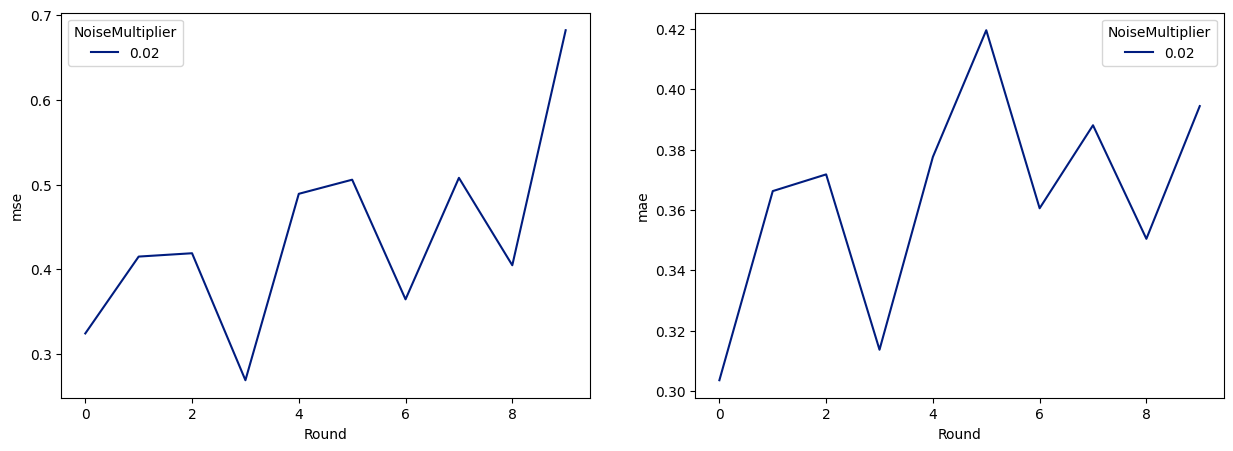

In [ ]:
make_plot(data_frame_mtr)

In [ ]:
print(data_frame_mtr.columns)

Index(['Round', 'learning_rate', 'NoiseMultiplier', 'mae', 'rae', 'mape',
       'mse', 'rse', 'rmse', 'mbe'],
      dtype='object')


In [ ]:
import matplotlib.pyplot as plt

def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast


def model_performance_visulization(model,series,scaler_std,window_size,split_time,visual):

    # Reshape the data to a 2D array as required by the scaler
    series = series.values.reshape(-1, 1)
    norm_series = scaler_std.transform(series)
    # Compute the forecast for all the series
    rnn_forecast = model_forecast(model, norm_series, window_size)
    # Reverse the standardization
    predictions = scaler_std.inverse_transform(rnn_forecast).squeeze()
    #test
    series=series.squeeze()
    print('series size:',len(series),series.shape)
    print('predictions size:',len(predictions),predictions.shape)
    print('valuessss',predictions[20],series[20])


    mae,rae,mape,mse,rse,rmse,mbe=compute_metrics(series[split_time:], predictions[split_time -window_size:-1])
    print('meeeeeeeee',mae,rae,mape,mse,rse,mbe)

    if(visual==True):
       #Plot actual and predicted values for the validation set
        plt.figure(figsize=(10, 6))

        plt.plot(series[split_time:], label='Actual')
        plt.plot(predictions[split_time -window_size:-1], label='Predicted')
        plt.xlabel('Time')
        plt.ylabel('Load')

        # # Add text boxes with MSE and MAE values
        plt.text(0.05, 0.95, f"mae: {mae:.2f}", transform=plt.gca().transAxes, fontsize=7, verticalalignment='top')
        plt.text(0.05, 0.9, f"rae: {rae:.2f}", transform=plt.gca().transAxes, fontsize=7, verticalalignment='top')
        plt.text(0.05, 0.85, f"mape: {mape:.2f}   ", transform=plt.gca().transAxes, fontsize=7, verticalalignment='top')
        plt.text(0.15, 0.95, f"mse: {mse:.2f}", transform=plt.gca().transAxes, fontsize=7, verticalalignment='top')
        plt.text(0.15, 0.85, f"rse: {rse:.2f}", transform=plt.gca().transAxes, fontsize=7, verticalalignment='top')
        plt.text(0.15, 0.9, f"rmse: {rmse:.2f}", transform=plt.gca().transAxes, fontsize=7, verticalalignment='top')
        plt.text(0.25, 0.95, f"mbe: {mbe:.2f}", transform=plt.gca().transAxes, fontsize=7, verticalalignment='top')
        plt.legend()
        plt.show()

        plt.figure(figsize=(10, 6))
        plt.plot(series[split_time:split_time+200], label='Actual')
        plt.plot(predictions[split_time -window_size:split_time -window_size+200], label='Predicted')
        plt.xlabel('Time')
        plt.ylabel('Load')

        # # Add text boxes with MSE and MAE values
        plt.text(0.05, 0.95, f"mse: {mse:.2f}", transform=plt.gca().transAxes, fontsize=10, verticalalignment='top')

        plt.text(0.05, 0.85, f"mae: {mae:.2f}", transform=plt.gca().transAxes, fontsize=10, verticalalignment='top')
        plt.legend()
        plt.show()
    dic={'mae':mae,'rae':rae,'mape':mape,'mse':mse,'rse':rse,'rmse':rmse,'mbe':mbe}

    return dic

908/908 [==============================] - 3s 3ms/step
series size: 29058 (29058,)
predictions size: 29051 (29051,)
valuessss 0.2177736 0.114
meeeeeeeee 0.18763368534463973 0.9892988924046564 34.66757944471284 0.10030339913700909 1.4145698249263505 0.3167071188606424


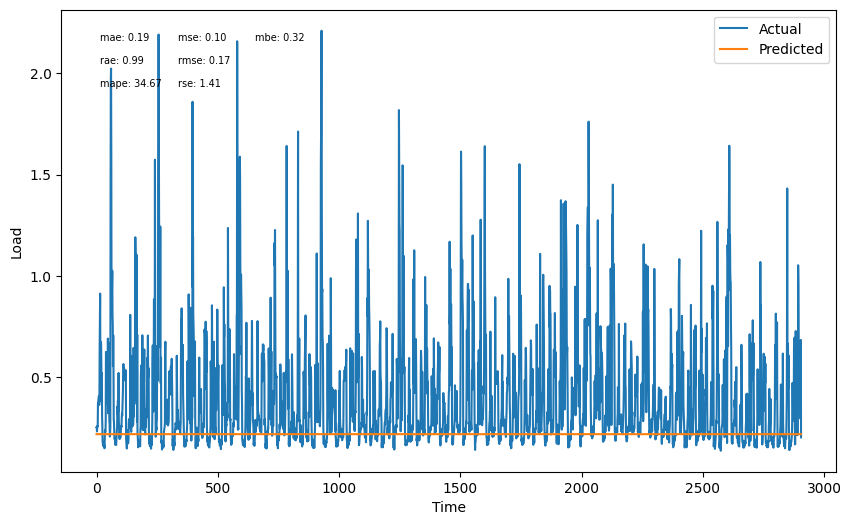

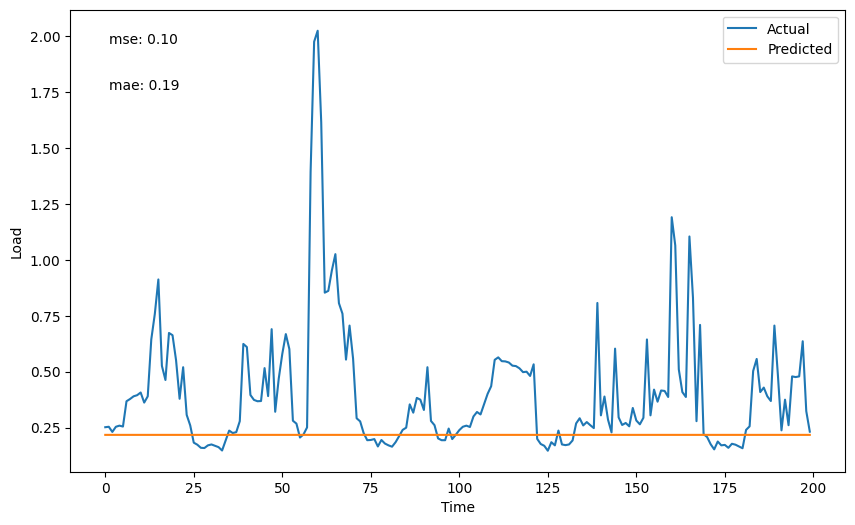

{'mae': 0.18763368534463973,
 'rae': 0.9892988924046564,
 'mape': 34.66757944471284,
 'mse': 0.10030339913700909,
 'rse': 1.4145698249263505,
 'rmse': 0.17145195912293948,
 'mbe': 0.3167071188606424}

In [ ]:
split_index = int(len(Mul_tie_fed_data_list[0][0]) * G.SPLIT_TIME)

series=Mul_tie_fed_data_list[0][90]
visual=True

#print(series)
split=int(G.SPLIT_TIME*len(series))
model_performance_visulization(model_evaluation,series,scaler_std,G.WINDOW_SIZE,split,visual)

In [ ]:
# # sampling_prob is small, it would be faster to use gap sampling.
#     x = np.random.uniform(size=len(multi_tier_fed_train_dataset[0]))
#     sampled_train_data = [
#         multi_tier_fed_train_dataset[0][i] for i in range(total_clients)
#         if x[i] < sampling_prob]

# single_federation_size=len(multi_tier_fed_train_dataset[0]) # for the single federation
# sampled_train_data_lis=[]

# for i in range(0,num_federations):
#   x = np.random.uniform(size=single_federation_size)
#   sampled_data=
#    multi_tier_fed_train_dataset, multi_tier_fed_test_dataset
noise_multiplier=0.7
clients_per_round=3
learning_rate=1e-7
num_local_rounds=3
rounds=400

for round in range(0,400):


# create and intialize learning process for all federations

list_of_learning_processes, list_of_states=create_DP_learning_processes(num_federations, noise_multiplier,  clients_per_round, learning_rate )
for index, item in enumerate(multi_tier_fed_train_dataset):
    total_clients=len(item)
    print(f'Index: {index}, Item: {len(item)}')
    train(rounds, noise_multiplier, clients_per_round, data_frame,total_clients,train_data):

In [ ]:
list_of_learning_processes, list_of_states=create_DP_learning_processes(num_federations,0.04,3,4e-4)

In [ ]:
model_weights = list_of_learning_processes[0].get_model_weights(list_of_states[0])

In [ ]:
print(model_weights.trainable)

In [ ]:
print(list_of_learning_processes[0])